In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [3]:
data = train_data.get()
data = data[data['fecha'] < '2020-11-12']
data.shape

(10536, 96)

In [4]:
target = 'is_next_peak_in_15_days'

In [5]:
experiment_round_length = pd.Grouper(freq='W')

experiment_rounds = data[
    data['fecha'] > data['fecha'].quantile(.5)
].set_index(
    'fecha'
).groupby(
    experiment_round_length)

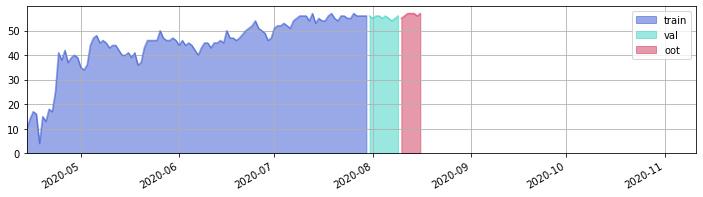

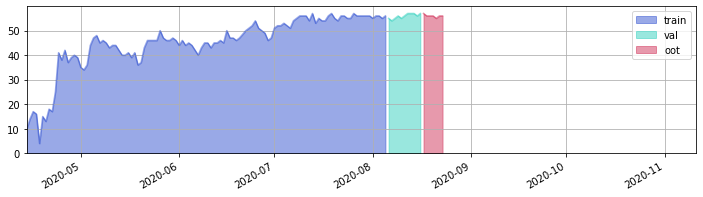

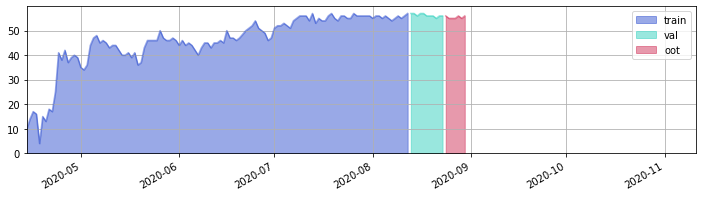

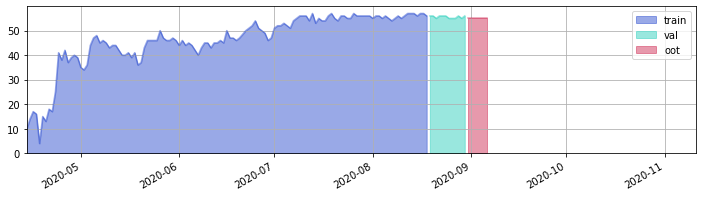

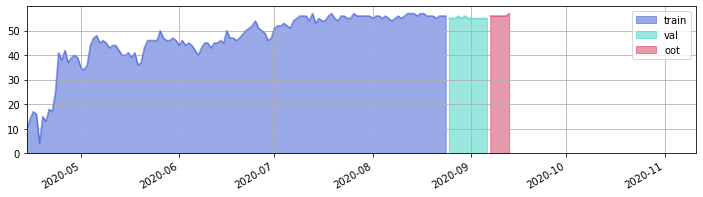

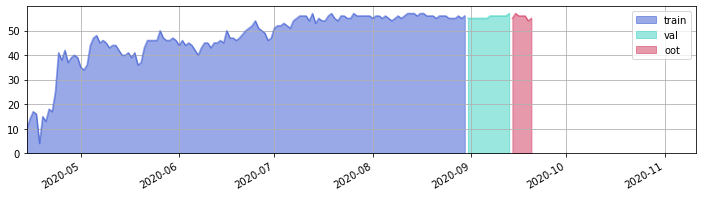

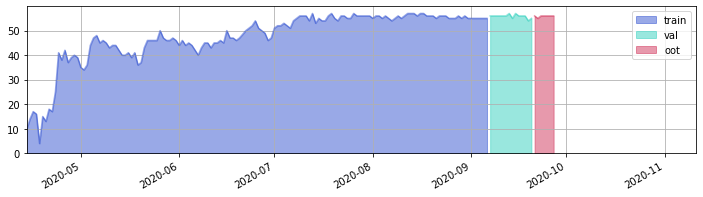

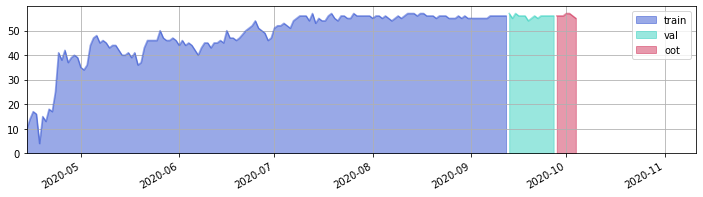

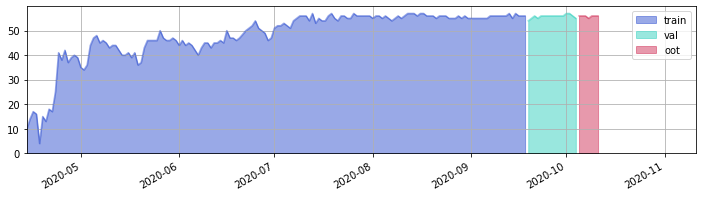

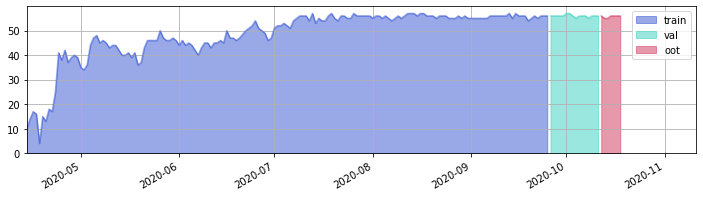

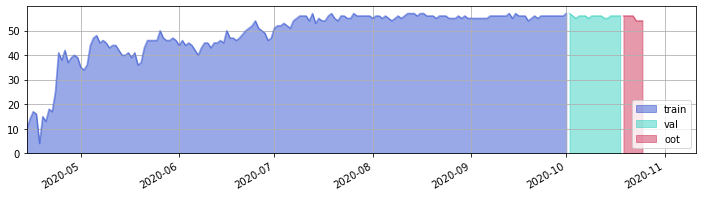

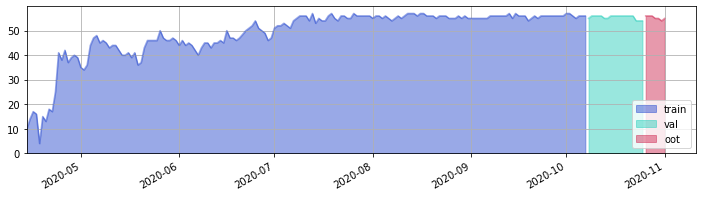

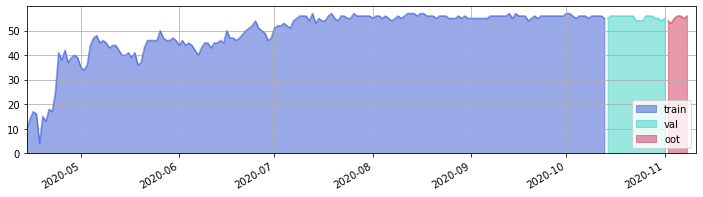

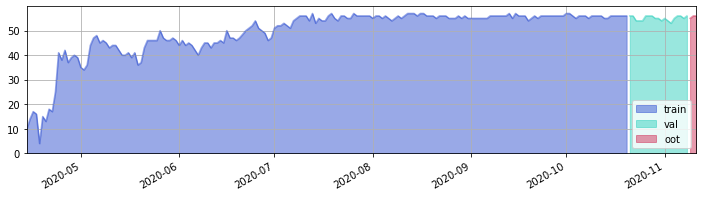

In [7]:
def plot_folds(X_train, X_val, X_oot):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))

    data_plot = train['fecha'].value_counts()
    data_plot.name = 'train'
    data_plot.plot(
        kind='area',
        color='#3454D1',
        grid=True,
        legend=True,
        alpha=.5,
        ax=ax)

    data_plot = val['fecha'].value_counts()
    data_plot.name = 'val'
    data_plot.plot(
        kind='area',
        color='#34D1BF', 
        grid=True,
        alpha=.5,
        legend=True, 
        ax=ax)

    data_plot = oot['fecha'].value_counts()
    data_plot.name = 'oot'
    data_plot.plot(
        kind='area',
        grid=True,
        alpha=.5,
        color='#D1345B',
        legend=True, 
        ax=ax)
    ax.set_xlim(
        date2num(data['fecha'].min()),
        date2num(data['fecha'].max()))
    
    return fig, ax


def get_train_val(data, date):
    """
    """
    train = data[data['fecha'] < date]

    oos_size = .1
    val_boundary = train['fecha'].quantile(1 - oos_size)

    val = train[train['fecha'] >= val_boundary]
    train = train[train['fecha'] < val_boundary]
    
    return train, val
    
    
    
for date, oot in experiment_rounds:
    oot.reset_index(inplace=True)
    
    train, val = get_train_val(data, oot['fecha'].min())
    
    plot_folds(train, val, oot)

In [7]:
train['fecha'].min()

Timestamp('2020-04-14 00:00:00')

In [8]:
val['fecha'].max()

Timestamp('2020-11-08 00:00:00')

In [9]:
oot['fecha'].min()

Timestamp('2020-11-09 00:00:00')

[00:29:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.956822  0.162989  0.278532   3399.0   579.0  0.788479
1             0.317909  0.981495  0.480261   1351.0  4171.0  0.788479
avg / total   0.775102  0.395789  0.335908   4750.0  4750.0  0.788479 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.975000  0.520992  0.679104    524.0  280.0  0.787055
1             0.083942  0.766667  0.151316     30.0  274.0  0.787055
avg / total   0.926748  0.534296  0.650524    554.0  554.0  0.787055 

oot 
              precision    re

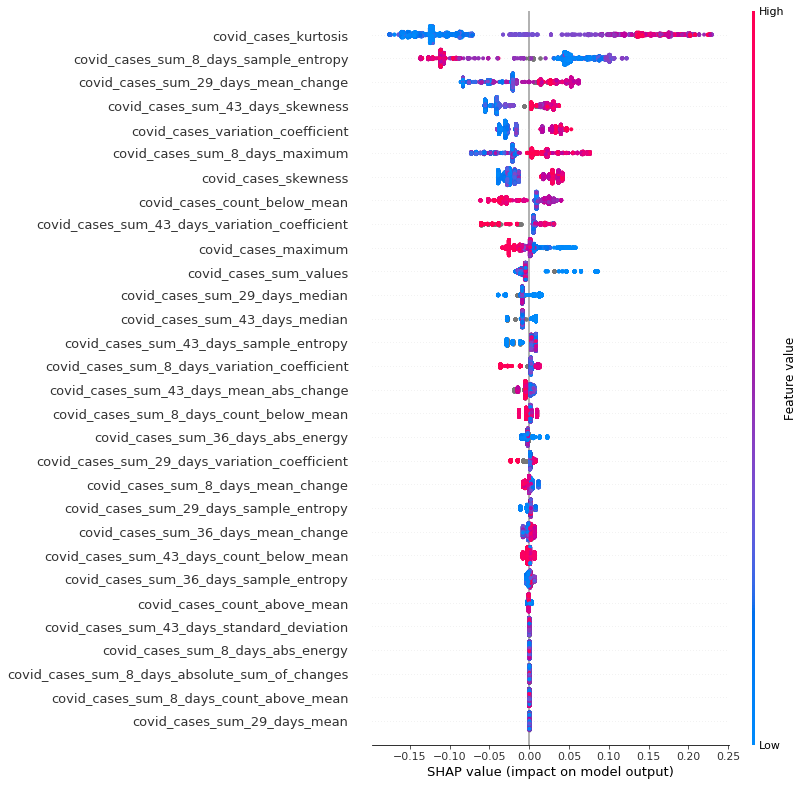

[00:29:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.986025  0.171067  0.291552   3712.0   644.0  0.825681
1             0.306982  0.993440  0.469030   1372.0  4440.0  0.825681
avg / total   0.802774  0.392998  0.339447   5084.0  5084.0  0.825681 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.944805  0.500861  0.654668    581.0  308.0  0.698998
1             0.055375  0.500000  0.099707     34.0  307.0  0.698998
avg / total   0.895633  0.500813  0.623987    615.0  615.0  0.698998 

oot 
              precision    re

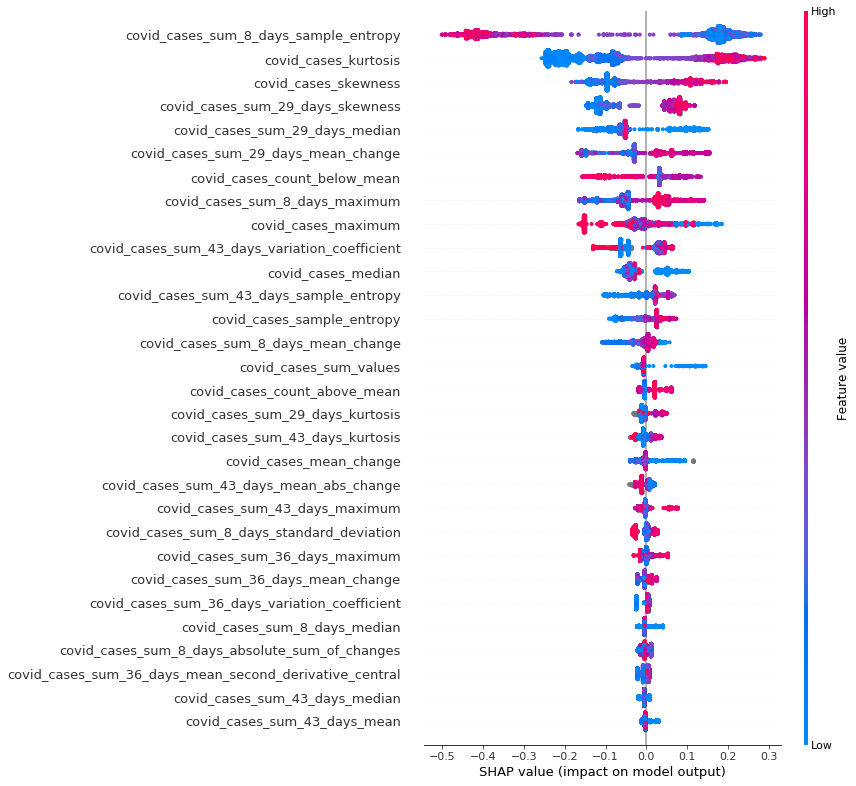

[00:29:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred      AUC
0             0.994444  0.175361  0.298147   4083.0   720.0  0.83362
1             0.291456  0.997120  0.451067   1389.0  4752.0  0.83362
avg / total   0.816000  0.383955  0.336964   5472.0  5472.0  0.83362 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.965398  0.485217  0.645833    575.0  289.0  0.833478
1             0.103030  0.772727  0.181818     44.0  330.0  0.833478
avg / total   0.904099  0.505654  0.612850    619.0  619.0  0.833478 

oot 
              precision    recall

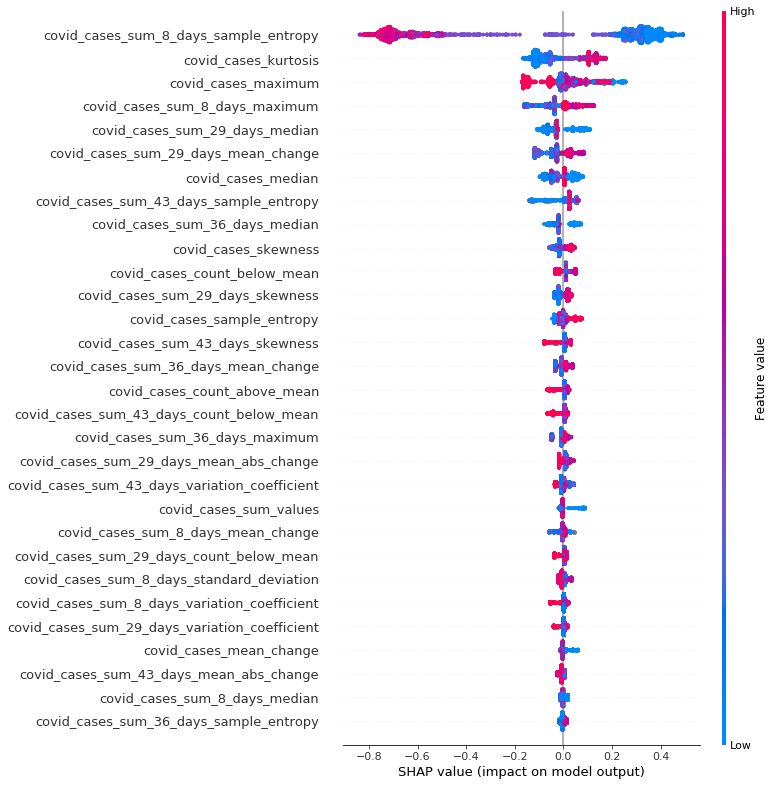

[00:29:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.985283  0.304526  0.465254   4397.0  1359.0  0.836687
1             0.313272  0.985866  0.475460   1415.0  4453.0  0.836687
avg / total   0.821674  0.470406  0.467739   5812.0  5812.0  0.836687 

val 
              precision    recall  f1-score  support   pred       AUC
0             1.000000  0.615506  0.761998    632.0  389.0  0.914127
1             0.125899  1.000000  0.223642     35.0  278.0  0.914127
avg / total   0.954133  0.635682  0.733748    667.0  667.0  0.914127 

oot 
              precision    re

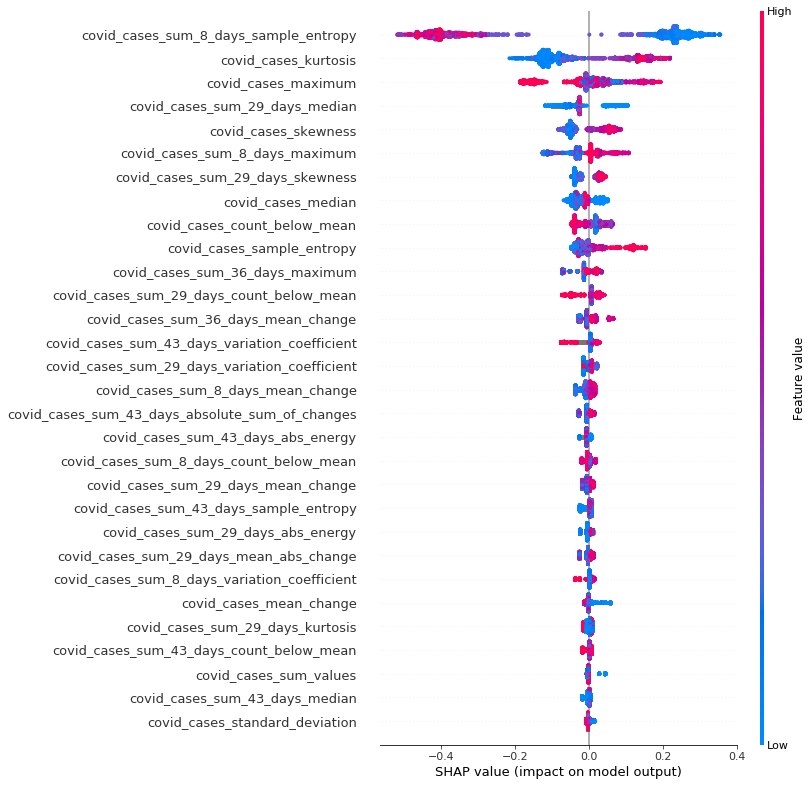

[00:29:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             1.000000  0.174698  0.297434   4711.0   823.0  0.848256
1             0.269722  1.000000  0.424852   1436.0  5324.0  0.848256
avg / total   0.829400  0.367496  0.327200   6147.0  6147.0  0.848256 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.995943  0.708514  0.827993    693.0  493.0  0.936328
1             0.098214  0.916667  0.177419     24.0  224.0  0.936328
avg / total   0.965894  0.715481  0.806217    717.0  717.0  0.936328 

oot 
              precision    re

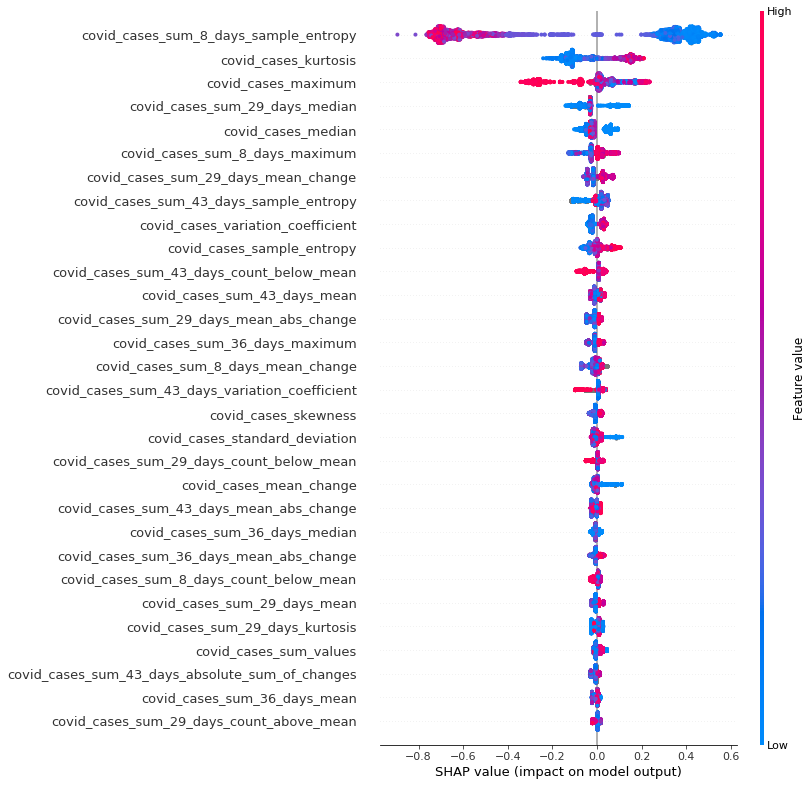

[00:29:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.997319  0.147942  0.257662   5029.0   746.0  0.847647
1             0.252573  0.998621  0.403174   1450.0  5733.0  0.847647
avg / total   0.830645  0.338324  0.290228   6479.0  6479.0  0.847647 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.978992  0.630582  0.767078    739.0  476.0  0.789407
1             0.096026  0.743590  0.170088     39.0  302.0  0.789407
avg / total   0.934730  0.636247  0.737152    778.0  778.0  0.789407 

oot 
              precision    re

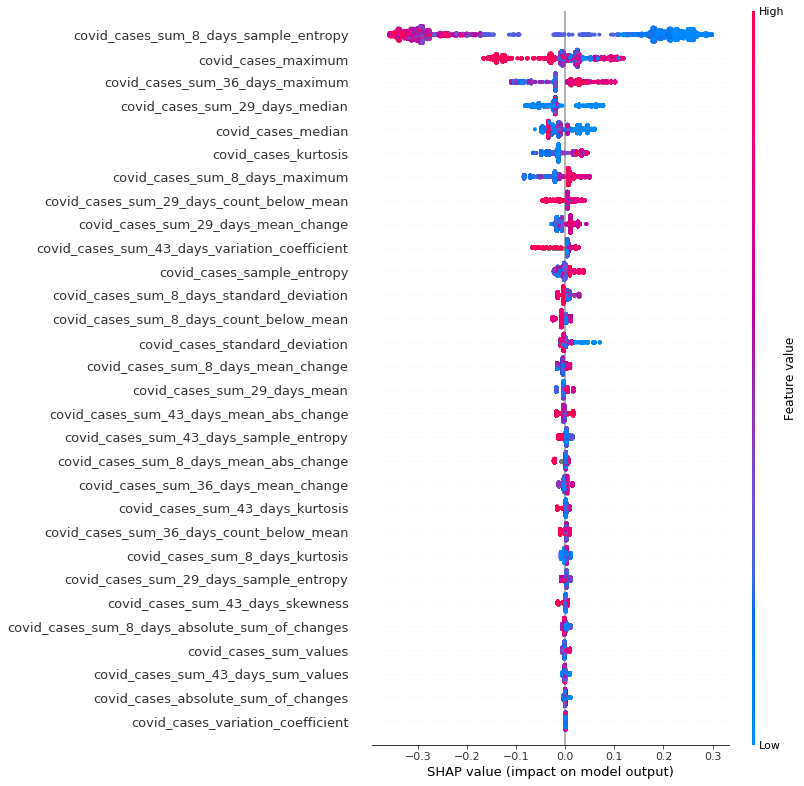

[00:29:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.996914  0.119541  0.213483   5404.0   648.0  0.847436
1             0.234556  0.998630  0.379885   1460.0  6216.0  0.847436
avg / total   0.834757  0.306527  0.248878   6864.0  6864.0  0.847436 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.962264  0.487040  0.646739    733.0  371.0  0.739622
1             0.085158  0.714286  0.152174     49.0  411.0  0.739622
avg / total   0.907305  0.501279  0.615750    782.0  782.0  0.739622 

oot 
              precision    re

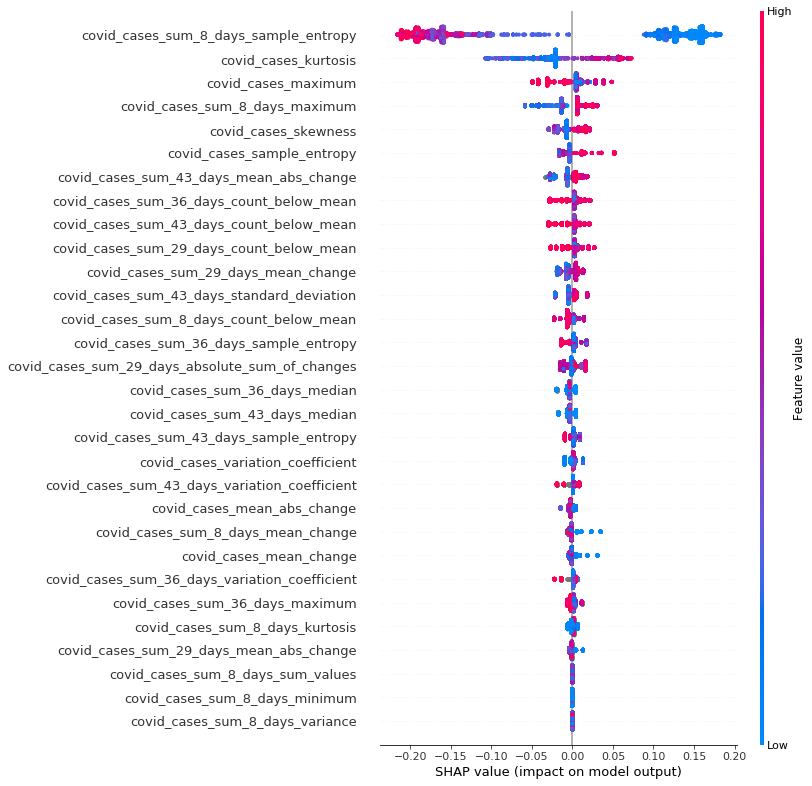

[00:29:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.994087  0.235304  0.380535   5716.0  1353.0  0.867058
1             0.252437  0.994609  0.402674   1484.0  5847.0  0.867058
avg / total   0.841225  0.391806  0.385098   7200.0  7200.0  0.867058 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.970968  0.753442  0.848485    799.0  620.0  0.807835
1             0.092166  0.526316  0.156863     38.0  217.0  0.807835
avg / total   0.931070  0.743130  0.817085    837.0  837.0  0.807835 

oot 
              precision    re

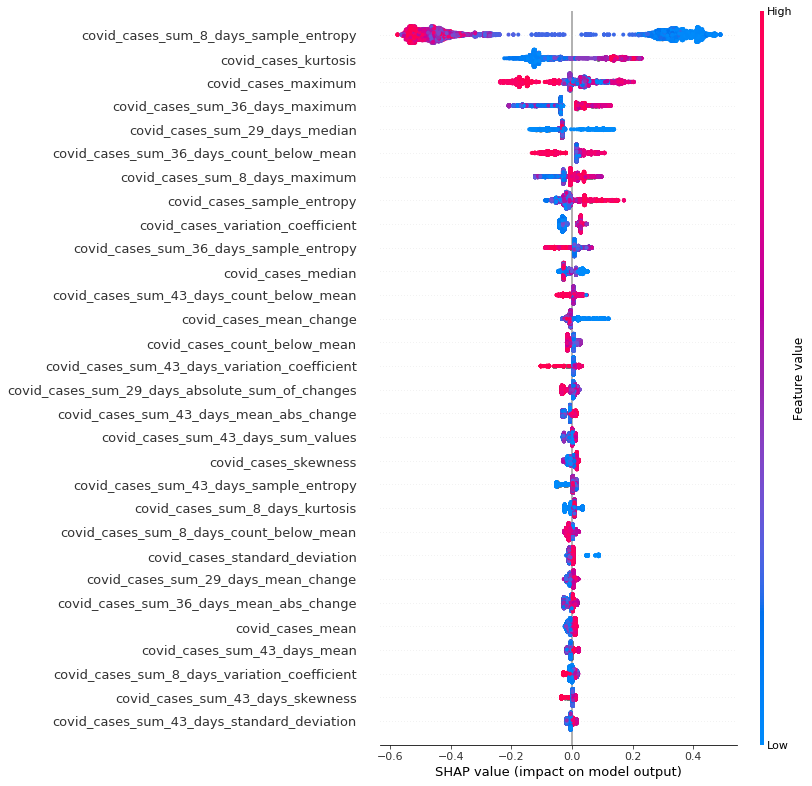

[00:29:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.991623  0.313992  0.476958   6032.0  1910.0  0.860615
1             0.264617  0.989369  0.417555   1505.0  5627.0  0.860615
avg / total   0.846453  0.448852  0.465096   7537.0  7537.0  0.860615 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.978134  0.779326  0.867485    861.0  686.0  0.806584
1             0.082126  0.531250  0.142259     32.0  207.0  0.806584
avg / total   0.946026  0.770437  0.841498    893.0  893.0  0.806584 

oot 
              precision    re

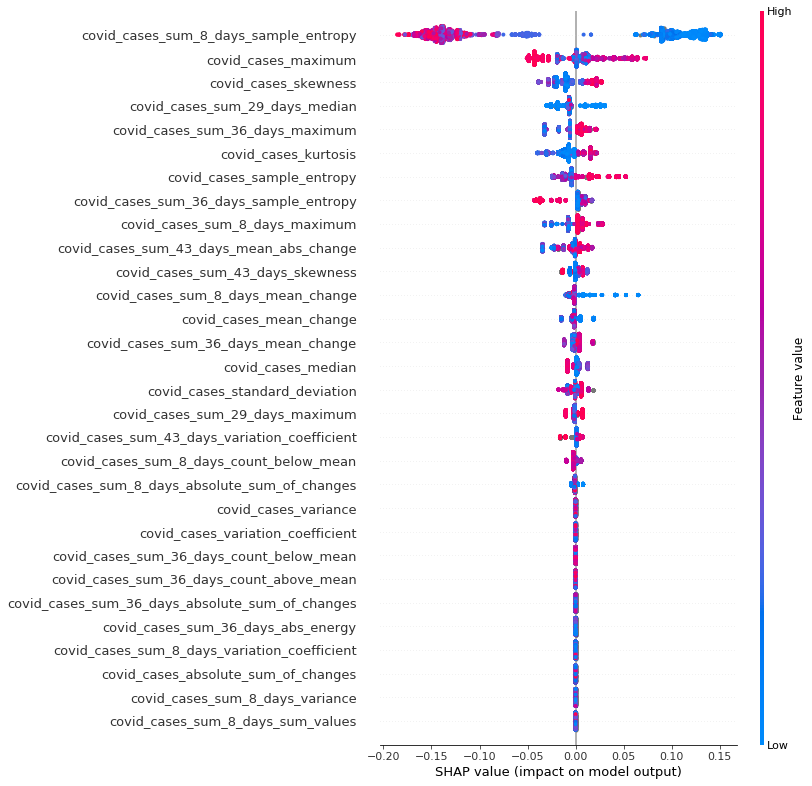

[00:29:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.998415  0.294990  0.455422   6407.0  1893.0  0.864866
1             0.251160  0.998024  0.401325   1518.0  6032.0  0.864866
avg / total   0.855282  0.429653  0.445060   7925.0  7925.0  0.864866 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.987261  0.540070  0.698198    861.0  471.0  0.842824
1             0.068235  0.828571  0.126087     35.0  425.0  0.842824
avg / total   0.951362  0.551339  0.675850    896.0  896.0  0.842824 

oot 
              precision    re

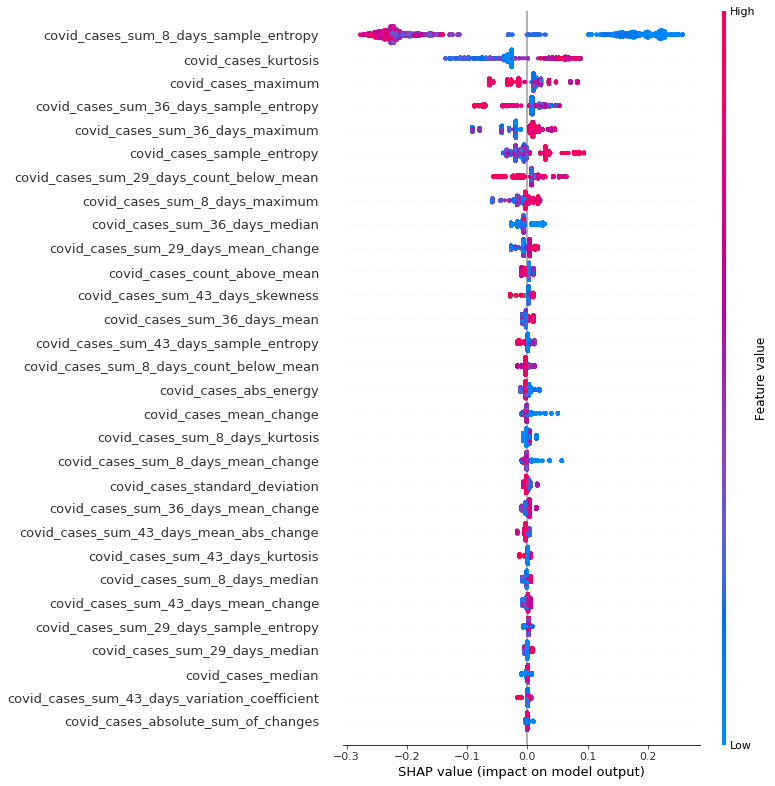

[00:29:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.991918  0.474075  0.641536   6731.0  3217.0  0.878778
1             0.298315  0.983018  0.457725   1531.0  5045.0  0.878778
avg / total   0.863389  0.568385  0.607475   8262.0  8262.0  0.878778 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.966206  0.700445  0.812137    898.0  651.0  0.801935
1             0.097315  0.568627  0.166189     51.0  298.0  0.801935
avg / total   0.919511  0.693361  0.777423    949.0  949.0  0.801935 

oot 
              precision    re

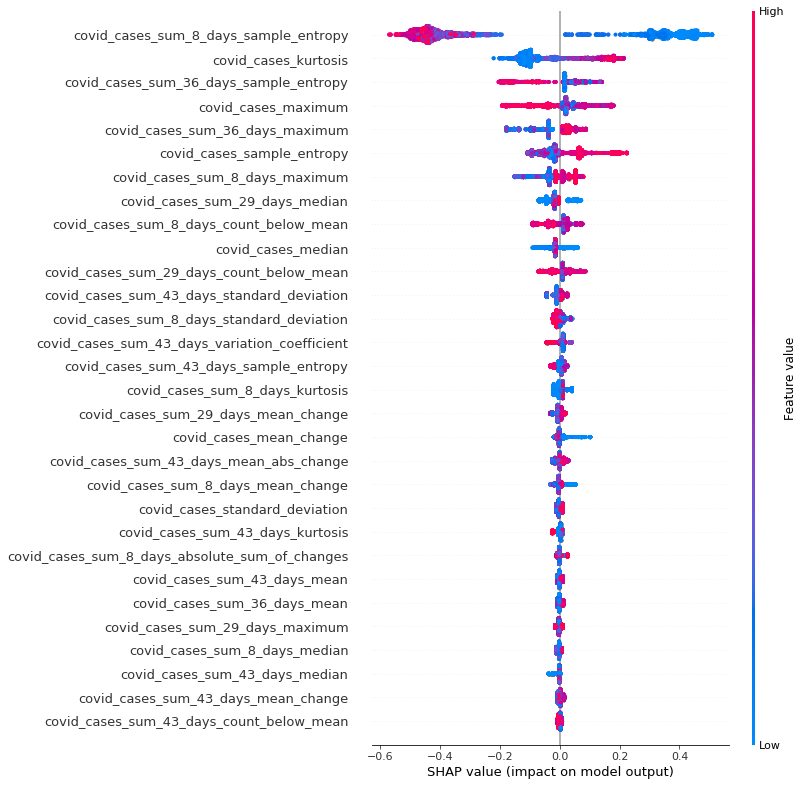

[00:29:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.992483  0.505101  0.669484   7058.0  3592.0  0.880144
1             0.302237  0.982468  0.462267   1540.0  5006.0  0.880144
avg / total   0.868852  0.590602  0.632369   8598.0  8598.0  0.880144 

val 
              precision    recall  f1-score  support   pred       AUC
0             0.962025  0.822511  0.886814    924.0  790.0  0.791385
1             0.215311  0.600000  0.316901     75.0  209.0  0.791385
avg / total   0.905966  0.805806  0.844028    999.0  999.0  0.791385 

oot 
              precision    re

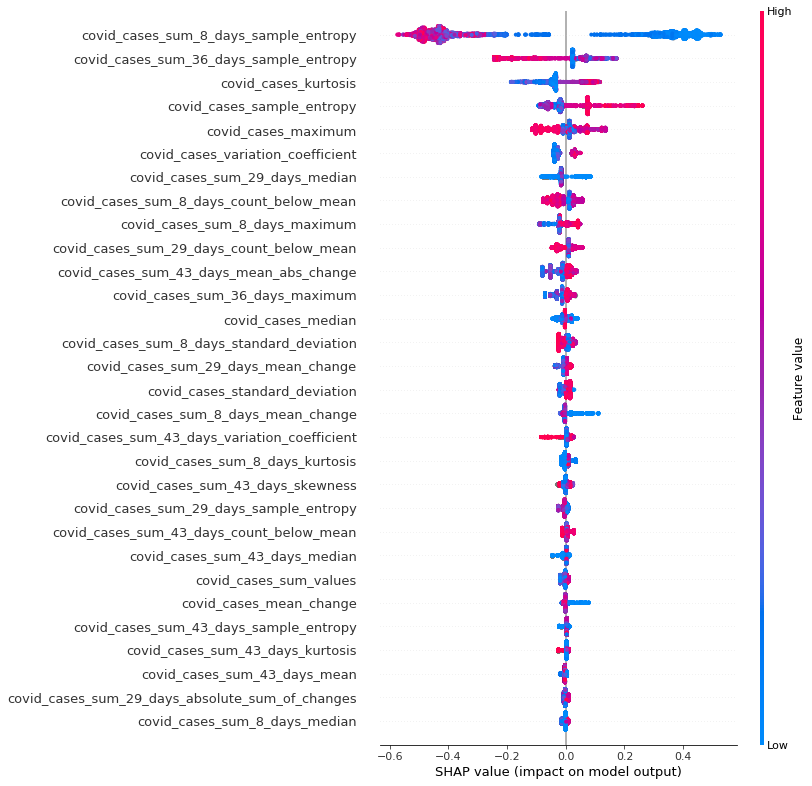

[00:30:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred       AUC
0             0.986240  0.447233  0.615399   7372.0  3343.0  0.864526
1             0.270889  0.970513  0.423556   1560.0  5589.0  0.864526
avg / total   0.861302  0.538625  0.581893   8932.0  8932.0  0.864526 

val 
              precision    recall  f1-score  support    pred       AUC
0             0.961998  0.909651  0.935092    974.0   921.0  0.821276
1             0.328244  0.551282  0.411483     78.0   131.0  0.821276
avg / total   0.915008  0.883080  0.896270   1052.0  1052.0  0.821276 

oot 
              precision  

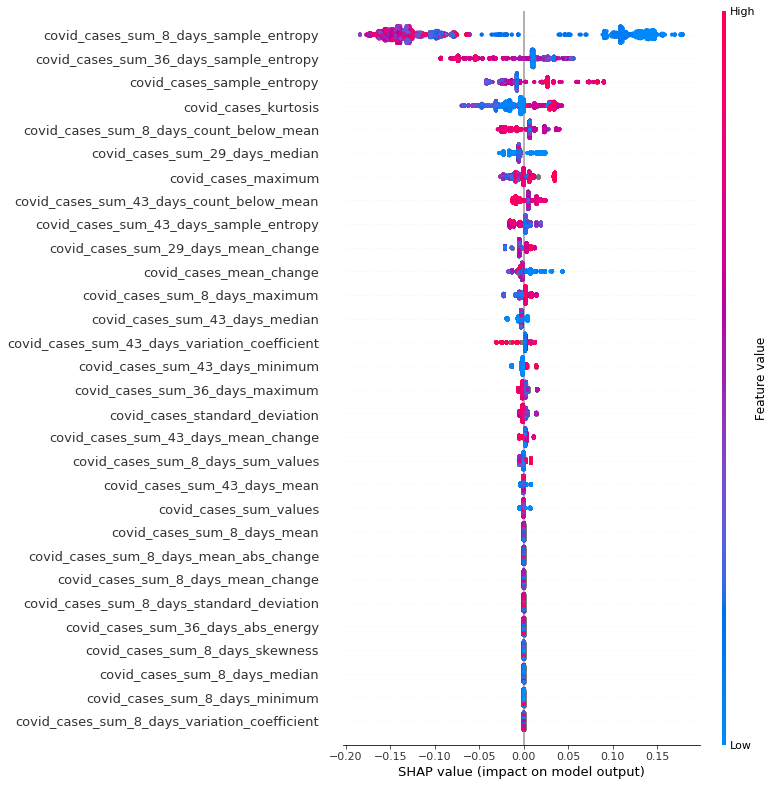

[00:30:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train 
              precision    recall  f1-score  support    pred      AUC
0             0.998578  0.454334  0.624522   7730.0  3517.0  0.88717
1             0.273510  0.996861  0.429247   1593.0  5806.0  0.88717
avg / total   0.874688  0.547034  0.591156   9323.0  9323.0  0.88717 

val 
              precision    recall  f1-score  support    pred      AUC
0             0.991004  0.671066  0.800242    985.0   667.0  0.86966
1             0.145119  0.901639  0.250000     61.0   379.0  0.86966
avg / total   0.941675  0.684512  0.768153   1046.0  1046.0  0.86966 

oot 
              precision    recall

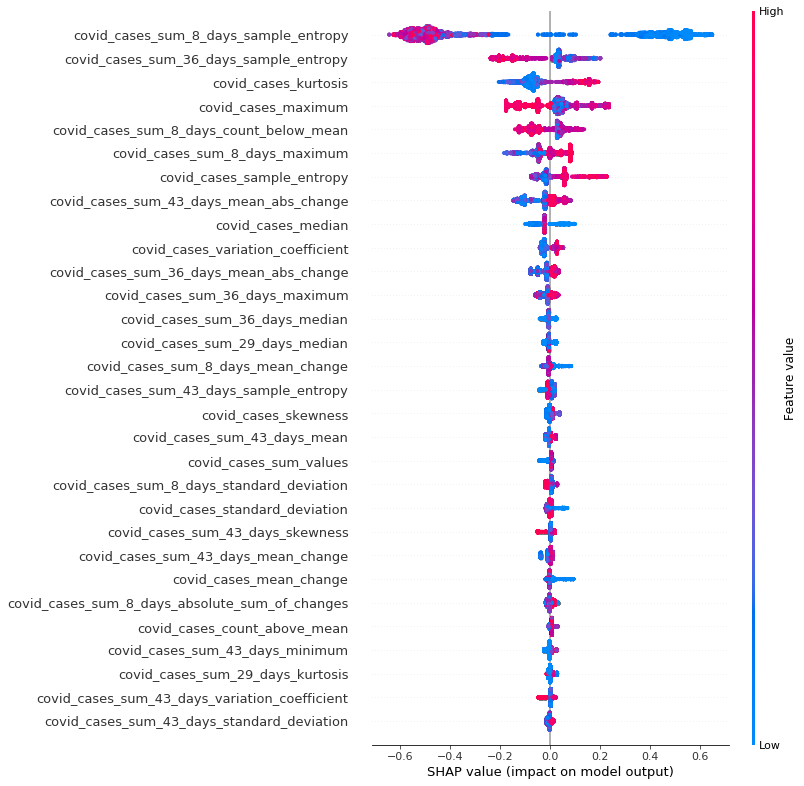

In [10]:
reports, feature_importance, dates = [], [], []
for date, oot in experiment_rounds:
    dates.append(date)
    oot.reset_index(inplace=True)
    
    # Split data
    train, val = get_train_val(data, oot['fecha'].min())
    
    # Get X matrix and y.
    X_train = train.set_index(['fecha', 'nombre_hospital']).copy()
    X_train.drop(list(set(X_train.columns).intersection(train_data._TARGETS)), axis=1, inplace=True)
    y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

    X_val = val.set_index(['fecha', 'nombre_hospital']).copy()
    X_val.drop(list(set(X_val.columns).intersection(train_data._TARGETS)), axis=1, inplace=True)
    y_val = val.set_index(['fecha', 'nombre_hospital'])[target]

    X_oot = oot.set_index(['fecha', 'nombre_hospital']).copy()
    X_oot.drop(list(set(X_oot.columns).intersection(train_data._TARGETS)), axis=1, inplace=True)
    y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]
       
    # Train model
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    model = xgb.XGBClassifier(
        subsample=.7,
        col_subsample=.5,
        max_depth=4,
        learning_rate=.05,
        min_child_weight=100,
        scale_pos_weight=scale_pos_weight)

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['logloss', 'auc'],
        early_stopping_rounds=10,
        verbose=False)

    # Evaluate
    y_train_score = model.predict_proba(X_train)
    y_val_score = model.predict_proba(X_val)
    y_oot_score = model.predict_proba(X_oot)
    
    score_th = pd.Series(y_oot_score[:, 1]).quantile(.5)
    
    report_train = eval_utils.classification_report(
        y_true=y_train, 
        y_score=y_train_score, 
        y_pred=(y_train_score[:, 1] > score_th).astype(int))

    report_val = eval_utils.classification_report(
        y_true=y_val, 
        y_score=y_val_score, 
        y_pred=(y_val_score[:, 1] > score_th).astype(int))

    report_oot = eval_utils.classification_report(
        y_true=y_oot, 
        y_score=y_oot_score, 
        y_pred=(y_oot_score[:, 1] > score_th).astype(int))
    
    local_reports = {
        'train': report_train,
        'val': report_val,
        'oot': report_oot,
        'date': date}
    reports.append(local_reports)
    
    [print(l,'\n', r, '\n') for l, r in local_reports.items()]
    
    # Plot feature importance
    fig, ax = plt.subplots(1, 1)
    explainer = shap.TreeExplainer(model)
    
    shaps_values = pd.DataFrame(
        explainer.shap_values(X_train),
        columns=X_train.columns)

    shap.summary_plot(
        shaps_values.values, 
        X_train,
        max_display=30)
    
    feature_importance.append(shaps_values.abs().sum(axis=0).sort_values())
    
feature_importance = pd.DataFrame(
    feature_importance,
    index=dates)

Text(0.5, 1.0, 'Evaluation Rounds\nAUC mean: 0.78')

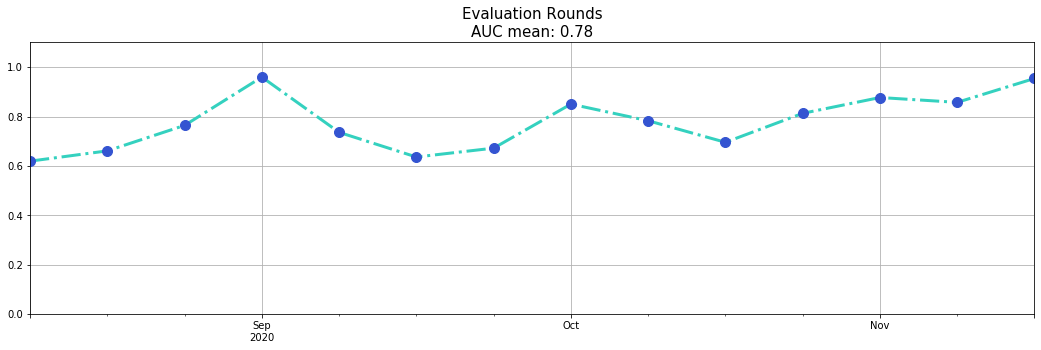

In [11]:
auc = pd.Series([r['oot']['AUC']['avg / total'] for r in reports])
auc.index = [r['date'] for r in reports]

auc_mean = auc.mean()

ax = auc.plot(
    marker='',
    linestyle='-.',
    linewidth=3,
    color='#34D1BF',
    grid=True,
    figsize=(18, 5),
    ylim=(.5, 1.1))

auc.plot(
    marker='o',
    markersize=10,
    linewidth=0,
    color='#3454D1',
    grid=True,
    figsize=(18, 5),
    ylim=(.0, 1.1))

ax.set_title('Evaluation Rounds\nAUC mean: %s' % round(auc_mean, 2), fontsize=15)

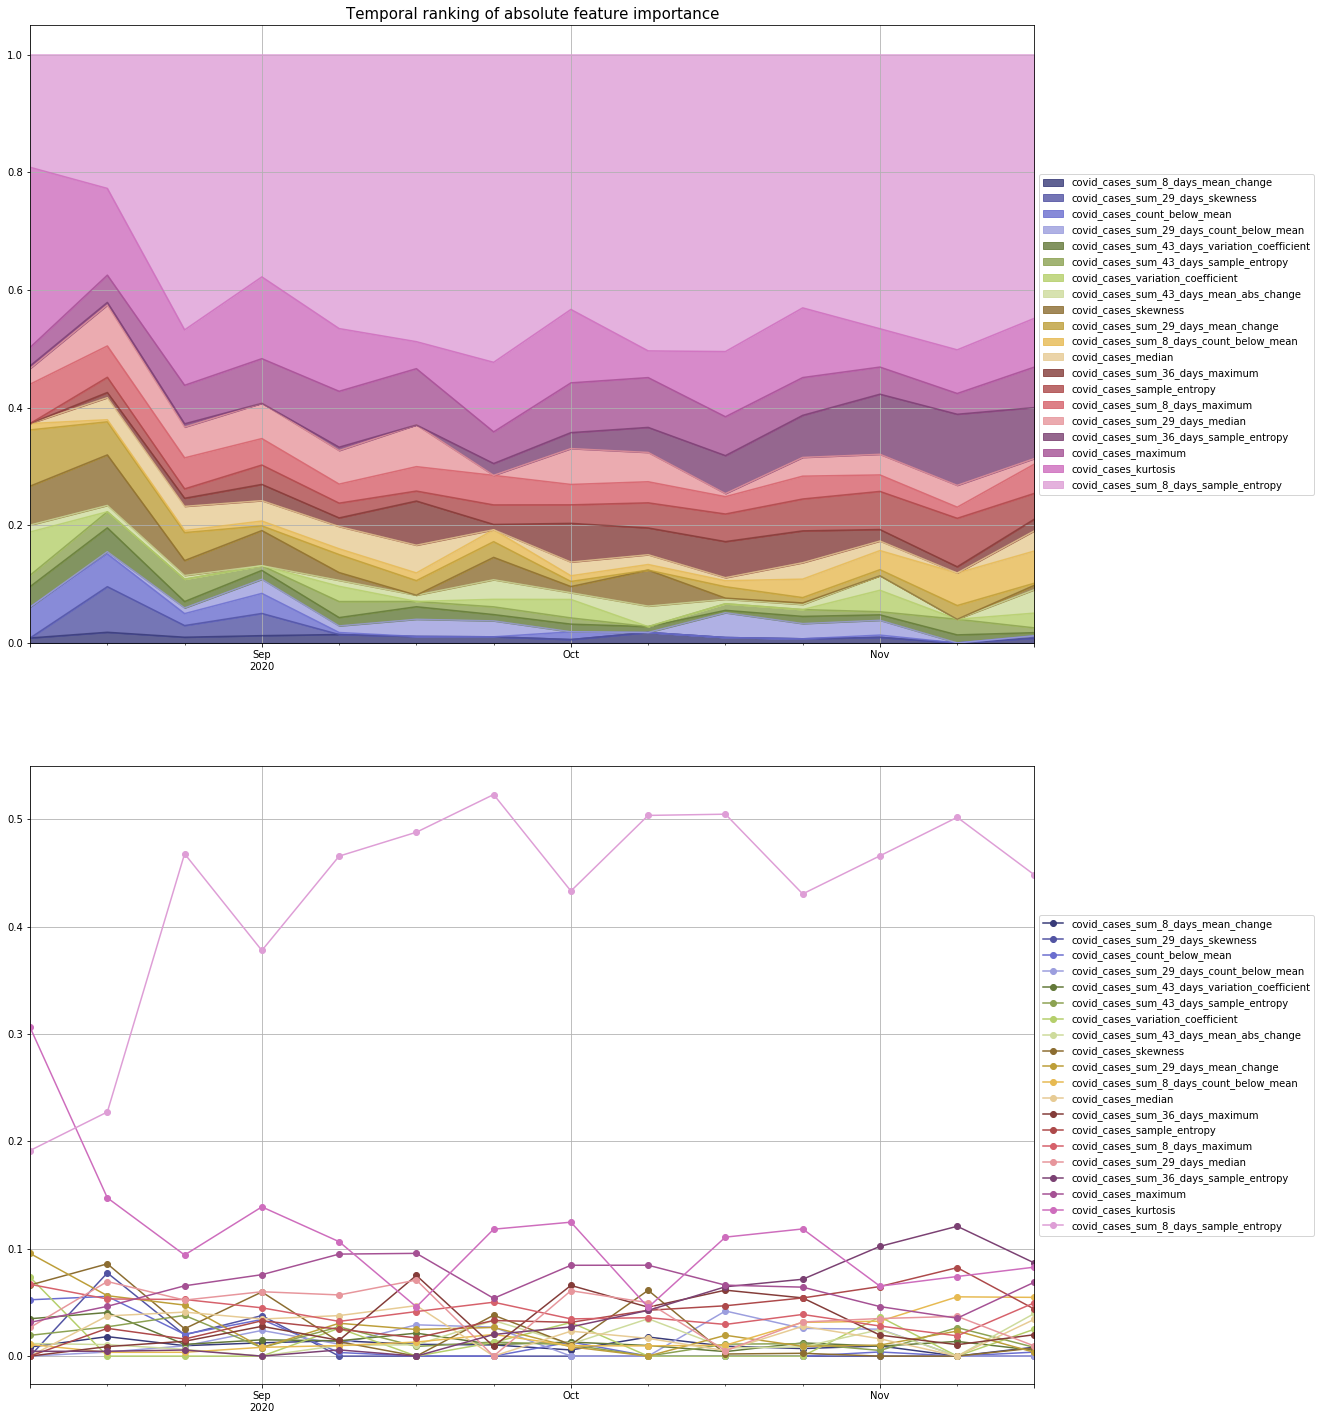

In [12]:
data_plot = feature_importance[feature_importance.sum().sort_values().iloc[-20:].index]
data_plot = (data_plot.T / data_plot.sum(axis=1)).T

fig, ax = plt.subplots(2, 1, figsize=(18, 25))
data_plot.plot(
    kind='area',
    stacked=True,
    ax=ax[0],
    grid=True,
    alpha=.8,
    cmap='tab20b')

data_plot.plot(
    marker='o', 
    ax=ax[1],
    cmap='tab20b',
    legend=False,
    grid=True)
ax[0].set_title('Temporal ranking of absolute feature importance', fontsize=15)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));